In [1]:
from geoband.API import *
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import pandas as pd
import json
from pandas import json_normalize
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from geoband.API import *
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopandas import GeoDataFrame
from folium import Choropleth
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from datetime import datetime 
import seaborn as sns
# GetCompasData로 주피터 노트북 경로에 파일 저장
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from fiona.crs import from_string
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from mgwr.utils import shift_colormap, truncate_colormap
import statsmodels.api as sm

matplotlib.rcParams['font.family']="Malgun Gothic"

In [4]:
from geoband.API import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import json
import geopandas as gpd
import os
import pydeck as pdk
import shapefile

In [5]:
#변수선택법

import time
import itertools

#회귀분석

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#공간회귀분석

import pysal
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
from libpysal.weights import Queen, Rook, KNN, DistanceBand, Kernel
from esda.getisord import G
from esda.moran import Moran
from spreg import OLS, ML_Lag, ML_Error, GM_Lag, GM_Error, TSLS

#정규성검정

from scipy.stats import shapiro

#다중공선성 체크

from statsmodels.stats.outliers_influence import variance_inflation_factor


#지리적가중회귀분석

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap


In [6]:
def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

In [7]:
#전진선택법

def forward(X,y,predictors):

    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
        results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()] #AIC가 가장 낮은 모델을 선택
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
#전진선택법 모델

def forward_model(X,y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
     
    predictors = []
    
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [8]:
#후진제거법

def backward(X,y,predictors):
    tic= time.time()
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X,y=y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['AIC'].argmin()]    # 가장 낮은 AIC를 가진 모델을 선택
    toc = time.time()
    
    print("Processed ",models.shape[0], "models on", len(predictors) - 1, "predictors in",(toc-tic))
    print("Selected predictors:",best_model['model'].model.exog_names,' AIC:',best_model[0])
    return best_model
    
def backward_model(X,y) :
    Bmodels = pd.DataFrame(columns=["AIC","model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=X, y= y, predictors=predictors)
        if Backward_result['AIC'] > Bmodel_before :
            break
        Bmodels.loc[len(predictors) -1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]['model'].model.exog_names
        Bmodel_before = Backward_result["AIC"]
        predictors = [k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return Bmodels["model"].dropna().iloc[0]

In [9]:
#변수선택법

def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns = ["AIC","model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors + ['const'])['AIC']
    
    
    for i in range(1,len(X.columns.difference(['const']))+1) :
        Forward_result = forward(X=X,y=y,predictors = predictors) # constant added
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X,y=y,predictors = predictors)
        if Backward_result["AIC"] < Forward_result["AIC"]:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [k for k in predictors if k != "const"]
            print('backward')
        if Stepmodels.loc[i]["AIC"] > Smodel_before:
            break
        else :
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:",(toc-tic),"seconds.")
    return (Stepmodels["model"][len(Stepmodels["model"])])

## 시작

In [2]:
# 수원시 데이터
df=gpd.read_file("테스트.geojson",driver="GeoJSON")
df.reset_index()
df.fillna(0, inplace=True)
df

,gid,상업지역면적,공업지역면적,주거지역면적,녹지지역면적,여성안심택배함_격자별개수,편의점_격자별개수,공원_격자별개수,안전비상벨_격자별개수,노숙인자활시설_격자별개수,...,공동주거건축물비율,사고다발지역,경찰서_Buffer면적,치안센터_Buffer면적,보안등_Buffer면적,가로등_Buffer면적,CCTV_Buffer면적,유흥업소_Buffer면적,rep_cnt,geometry
0,다사49aa19ab,0.0,0.0,0.0,1.533091e-06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,다사49aa19ba,0.0,0.0,0.0,2.217984e-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."
2,다사49aa20aa,0.0,0.0,0.0,1.536883e-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ..."
3,다사49ab18ab,0.0,0.0,0.0,6.017091e-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ..."
4,다사49ab18ba,0.0,0.0,0.0,3.456896e-06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,다사63ba21aa,0.0,0.0,0.0,1.206657e-06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((127.08822 37.28722, 127.08821 ..."
2086,다사63ba21ab,0.0,0.0,0.0,9.069994e-08,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((127.08821 37.28947, 127.08820 ..."
2087,다사63ba21ba,0.0,0.0,0.0,7.868796e-07,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,"MULTIPOLYGON (((127.08820 37.29173, 127.08819 ..."
2088,다사63ba21bb,0.0,0.0,0.0,2.346309e-06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.374772e-08,0.0,0.0,0,"MULTIPOLYGON (((127.08819 37.29398, 127.08818 ..."


In [10]:
# 수치형 변수만 남김
X=df.drop(['gid', 'geometry', 'rep_cnt'], axis=1)
X.fillna(0, inplace=True)

# 종속변수 지정
y=pd.DataFrame(df.loc[:, 'rep_cnt'])

In [34]:
## 수원시용
gdf = gpd.read_file('32.수원시_표준격자(250M_x_250M).geojson')
gdf = gpd.GeoDataFrame(gdf, geometry=gdf.geometry)

In [12]:
#전체 독립변수를 대상으로 다중공선성 확인

vif_acc_risk = pd.DataFrame()
vif_acc_risk['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_acc_risk['features'] = X.columns
vif_acc_risk

,VIF Factor,features
0,2.720719,상업지역면적
1,1.712545,공업지역면적
2,7.119867,주거지역면적
3,2.038417,녹지지역면적
4,1.097865,여성안심택배함_격자별개수
...,...,...
82,1.757813,치안센터_Buffer면적
83,354.195829,보안등_Buffer면적
84,1426.205228,가로등_Buffer면적
85,15.310268,CCTV_Buffer면적


In [13]:
len(vif_acc_risk[vif_acc_risk['VIF Factor']<=10])

26

In [14]:
#독립변수들의 계수의 크기를 명확히 비교하기 위해 독립변수를 대상으로 Min-Max scaling 진행

scaler = MinMaxScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

scaled_X = pd.DataFrame(scaled_X)
scaled_X.columns = list(X.columns)

scaled_X = sm.add_constant(scaled_X, has_constant='add')

scaled_X

,const,상업지역면적,공업지역면적,주거지역면적,녹지지역면적,여성안심택배함_격자별개수,편의점_격자별개수,공원_격자별개수,안전비상벨_격자별개수,노숙인자활시설_격자별개수,...,30년이상건축물비율,단독주거건축물비율,공동주거건축물비율,사고다발지역,경찰서_Buffer면적,치안센터_Buffer면적,보안등_Buffer면적,가로등_Buffer면적,CCTV_Buffer면적,유흥업소_Buffer면적
0,1.0,0.0,0.0,0.0,0.120595,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,1.0,0.0,0.0,0.0,0.017447,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,1.0,0.0,0.0,0.0,0.012089,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,1.0,0.0,0.0,0.0,0.047331,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
4,1.0,0.0,0.0,0.0,0.271925,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,1.0,0.0,0.0,0.0,0.094917,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2086,1.0,0.0,0.0,0.0,0.007135,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2087,1.0,0.0,0.0,0.0,0.061897,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2088,1.0,0.0,0.0,0.0,0.184564,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01522,0.0,0.0


In [15]:
#전체 독립변수를 대상으로 다중공선성 재확인

vif_acc_risk_scaled = pd.DataFrame()
vif_acc_risk_scaled['VIF Factor'] = [variance_inflation_factor(scaled_X.values, i) for i in range(scaled_X.shape[1])]
vif_acc_risk_scaled['features'] = scaled_X.columns
vif_acc_risk_scaled

,VIF Factor,features
0,10.731210,const
1,2.661108,상업지역면적
2,1.861531,공업지역면적
3,5.067217,주거지역면적
4,2.490793,녹지지역면적
...,...,...
83,1.635551,치안센터_Buffer면적
84,284.870925,보안등_Buffer면적
85,844.377693,가로등_Buffer면적
86,9.377641,CCTV_Buffer면적


In [16]:
# 스케일링 전 26개 -> 스케일링 후 29개를 선택
len(vif_acc_risk_scaled[vif_acc_risk_scaled['VIF Factor']<=10])

29

In [17]:
# 열별 정규화
standard_X=X.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [18]:
#전체 독립변수를 대상으로 다중공선성 재확인

vif_acc_risk_standard = pd.DataFrame()
vif_acc_risk_standard['VIF Factor'] = [variance_inflation_factor(standard_X.values, i) for i in range(standard_X.shape[1])]
vif_acc_risk_standard['features'] = standard_X.columns
vif_acc_risk_standard

,VIF Factor,features
0,2.661108,상업지역면적
1,1.861531,공업지역면적
2,5.067217,주거지역면적
3,2.490793,녹지지역면적
4,1.094789,여성안심택배함_격자별개수
...,...,...
82,1.635551,치안센터_Buffer면적
83,284.870925,보안등_Buffer면적
84,844.377693,가로등_Buffer면적
85,9.377641,CCTV_Buffer면적


In [19]:
# 정규화해도 29개
len(vif_acc_risk_standard[vif_acc_risk_standard['VIF Factor']<=10])

29

In [22]:
selected_X_list=list(vif_acc_risk_scaled[vif_acc_risk_scaled['VIF Factor']<=10]['features'])
selected_X_list.append('const')
scaled_X=scaled_X[selected_X_list]

In [23]:
step_best_model_ctc = Stepwise_model(scaled_X, y)

Processed  29 models on 1 predictors in 0.08454704284667969
Selected predictors: ['편의점_격자별개수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f03aff8a080>
forward
Processed  1 models on 0 predictors in 0.003753662109375
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f03aff73ef0>
Processed  28 models on 2 predictors in 0.051593780517578125
Selected predictors: ['편의점_격자별개수', '경찰서_치안센터_격자별개수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f03aff73128>
forward
Processed  2 models on 1 predictors in 0.003966569900512695
Selected predictors: ['편의점_격자별개수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f03b1258160>
Processed  27 models on 3 predictors in 0.03942608833312988
Selected predictors: ['편의점_격자별개수', '경찰서_치안센터_격자별개수', '상업지역면적', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResu

In [24]:
step_best_model_ctc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                rep_cnt   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     202.3
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:42:19   Log-Likelihood:                -13647.
No. Observations:                2090   AIC:                         2.733e+04
Df Residuals:                    2073   BIC:                         2.742e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
편의점_격자별개수        723.7533     47.736     15.162      0.000     630.138     817.368
경찰서_치안센터_격자별개수   718.2716     32.839     21.873      0.000     653.872     782.672
상업지역면적           427.1833     29.265     14.597      0.000     369.792     484.574
사고다발지역           638.0914     49.807     12.811      0.000     540.414     735.768
CCTV_격자별개수       127.0059     34.085      3.726      0.000      60.162     193.850
무료급식소_격자별개수     1182.8885    168.403      7.024      0.000     852.632    1513.145
35년이상건축물수        270.7554     45.728      5.921      0.000     181.078     360.433
30~34년건축물수       227.7042     52.763      4.316      0.000     124.230     331.179
어린이놀이시설_격자별개수    147.8891     67.726      2.184      0.029      15.071     280.707
30년이상건축물비율      -364.7271     86.947     -4.195      0.000    -535.239    -194.215
단독주거건축물비율        -96.5029     20.097     -4.802      0.000    -135.916     -57.090
개별주택가격            90.5766     33.702      2.688      0.007      24.483     156.670
주거지역면적            55.8038     27.710      2.014      0.044       1.462     110.146
경찰서_Buffer면적     -30.3172     15.196     -1.995      0.046     -60.119      -0.516
공업지역면적           -51.8744     23.630     -2.195      0.028     -98.216      -5.533
주거용도용적률           80.2724     45.108      1.780      0.075      -8.189     168.733
const              1.9277      5.332      0.362      0.718      -8.529      12.385
==============================================================================
Omnibus:                     2501.776   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           590407.191
Skew:                           5.942   Prob(JB):                         0.00
Kurtosis:                      84.478   Cond. No.                         49.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
step_best_model_ctc.params

편의점_격자별개수          723.753263
경찰서_치안센터_격자별개수     718.271628
상업지역면적             427.183269
사고다발지역             638.091382
CCTV_격자별개수         127.005925
무료급식소_격자별개수       1182.888532
35년이상건축물수          270.755403
30~34년건축물수         227.704231
어린이놀이시설_격자별개수      147.889082
30년이상건축물비율        -364.727105
단독주거건축물비율          -96.502872
개별주택가격              90.576569
주거지역면적              55.803822
경찰서_Buffer면적       -30.317168
공업지역면적             -51.874408
주거용도용적률             80.272399
const                1.927706
dtype: float64

In [26]:
step_selected_X_list=list(step_best_model_ctc.params.index)
scaled_X=scaled_X[step_selected_X_list]

<AxesSubplot:title={'center':'Person Correlation of Features'}>

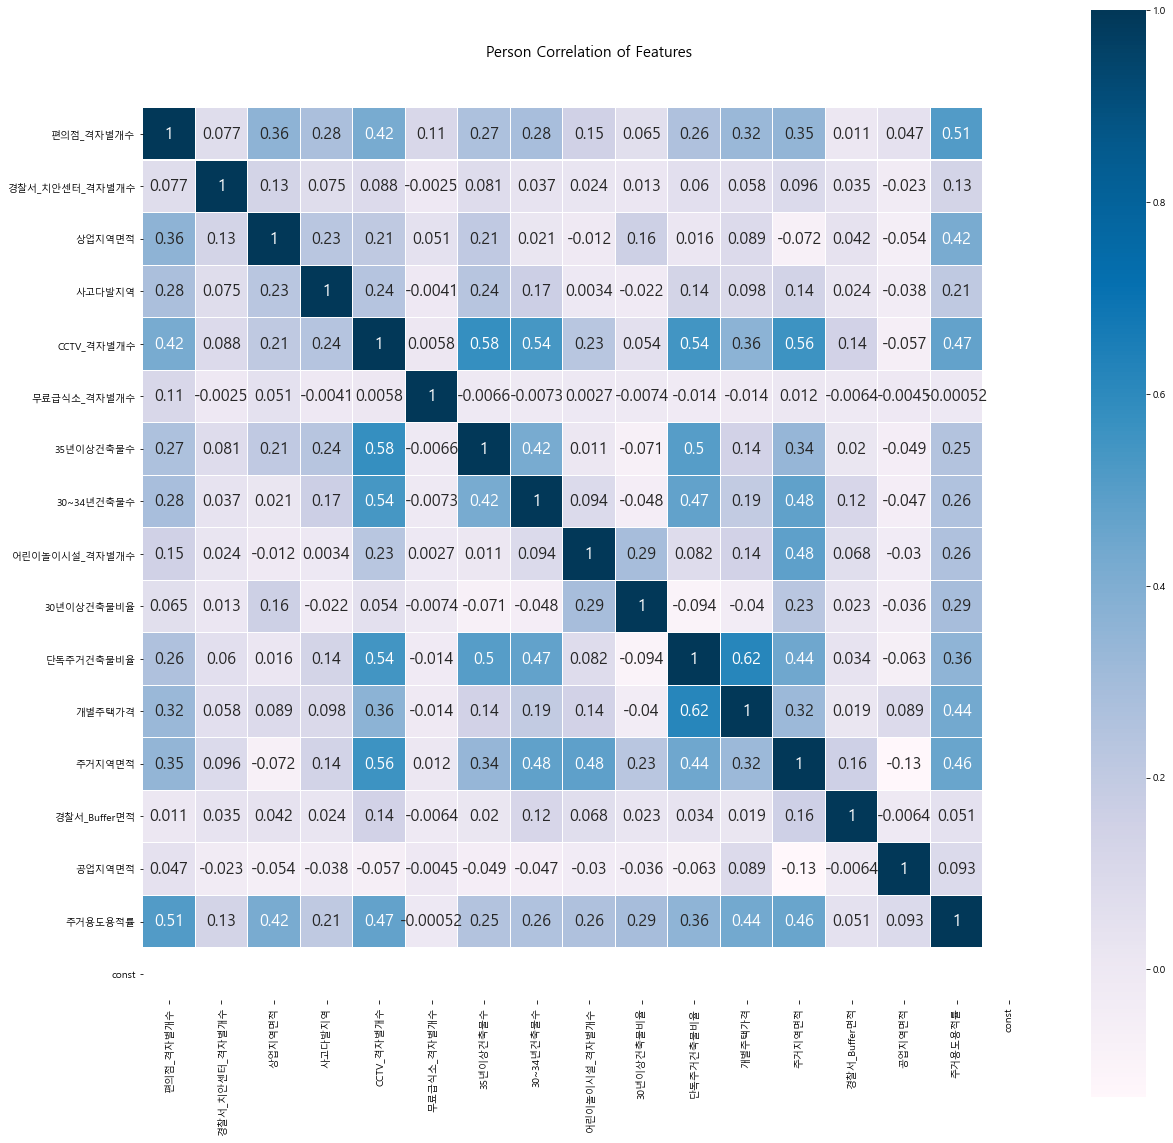

In [27]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(20, 20)) 
plt.title("Person Correlation of Features", y = 1.05, size = 15) 
sns.heatmap(scaled_X.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, 
            linecolor = "white", annot = True, annot_kws = {"size" : 16})


### 히트맵에서 공선성 0.8 넘는거 있으면 보고 빼야함

# -------변수 선택 끝(다중공선, Stepwise)----------

In [28]:
#OLS모형을 적합하는 과정을 함수로 정의

def ols(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    ols = OLS(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y, white_test = True, spat_diag = True, moran = True)
    
    print(ols.summary)
    
    return ols

In [29]:
#SEM_GM모형을 적합하는 과정을 함수로 정의

def gmerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmerror = GM_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    
    print(gmerror.summary)
    
    return gmerror

In [30]:
#SEM_ML모형을 적합하는 과정을 함수로 정의

def mlerror(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mlerror = ML_Error(y = y, x = x, w = w_matrix, name_x = name_x, name_y = name_y)
    stat_Q_risk, p_Q_risk = shapiro(mlerror.e_filtered)
    
    print(stat_Q_risk, p_Q_risk)
    print(mlerror.summary)
    
    return mlerror

In [31]:
#SLM_GM모형을 적합하는 과정을 함수로 정의

def gmlag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    gmlag = GM_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(gmlag.summary)
    
    return gmlag

In [32]:
#SLM_ML모형을 적합하는 과정을 함수로 정의

def mllag(data_x, data_y, w_matrix):
    x = np.array(data_x)
    y = np.array(data_y)
    
    name_x = list(data_x.columns)
    name_y = list(data_y.columns)
    
    mllag = ML_Lag(y = y, x = x, w = w_matrix, name_x = name_x)
    
    print(mllag.summary)
    
    return mllag

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

## 회귀 모델

In [35]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

In [36]:
# 정규성 검정
shapiro(y)

ShapiroResult(statistic=0.39868927001953125, pvalue=0.0)

## 모란지수 참고
- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

In [37]:
ols_Q_ctc = ols(scaled_X, y, w)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['rep_cnt']                Number of Observations:        2090
Mean dependent var  :    107.0641                Number of Variables   :          17
S.D. dependent var  :    265.4280                Degrees of Freedom    :        2073
R-squared           :      0.6096
Adjusted R-squared  :      0.6065
Sum squared residual:57462393.682                F-statistic           :    202.2765
Sigma-square        :   27719.437                Prob(F-statistic)     :           0
S.E. of regression  :     166.492                Log likelihood        :  -13647.281
Sigma-square ML     :   27493.968                Akaike info criterion :   27328.562
S.E of regression ML:    165.8131                Schwarz criterion     :   27424.526

-----------------------------------------------------------------------------

In [38]:
gmerror_Q_ctc = gmerror(scaled_X, y, w) #GMM 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : ['rep_cnt']                Number of Observations:        2090
Mean dependent var  :    107.0641                Number of Variables   :          17
S.D. dependent var  :    265.4280                Degrees of Freedom    :        2073
Pseudo R-squared    :      0.6056

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      13.1205877       9.8195395       1.3361714       0.1814933
           편의점_격자별개수     636.5101167      42.5781685      14.9492131       0.0000000
      경찰서_치안센터_격자별개수     708.6618635      28.3185612      25.0246423       0.0000000
      

In [39]:
gmlag_D_cth = gmlag(scaled_X, y, w) #2SLS 추정

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        2090
Mean dependent var  :    107.0641                Number of Variables   :          18
S.D. dependent var  :    265.4280                Degrees of Freedom    :        2072
Pseudo R-squared    :      0.6887
Spatial Pseudo R-squared:  0.6167

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -3.8124613       4.7658056      -0.7999616       0.4237331
           편의점_격자별개수     672.1757450      42.6671745      15.7539315       0.0000000
      경찰서_치안센터_격자별개수     731.2717732      29.2421867      2

In [40]:
#전역적 Moran's I

mi = Moran(y, w)
mi.I, mi.p_sim

(0.4639155681963931, 0.001)

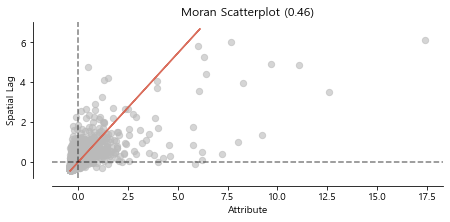

In [41]:
fig, ax = moran_scatterplot(mi, aspect_equal=True, p=0.05)
plt.show()

In [42]:
#지역적 Moran's I

mil = Moran_Local(y, w)
mil.Is.shape

(2090,)

In [43]:
mil.p_z_sim[0]

0.22307337013872885

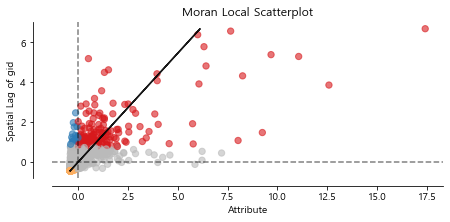

In [44]:
fig, ax = moran_scatterplot(mil, aspect_equal=True, p=0.05)
ax.set_ylabel('Spatial Lag of gid')
plt.show()

In [45]:
idx = mil.p_sim < 0.05
mil.p_sim[idx]

array([0.003, 0.003, 0.018, ..., 0.004, 0.004, 0.017])

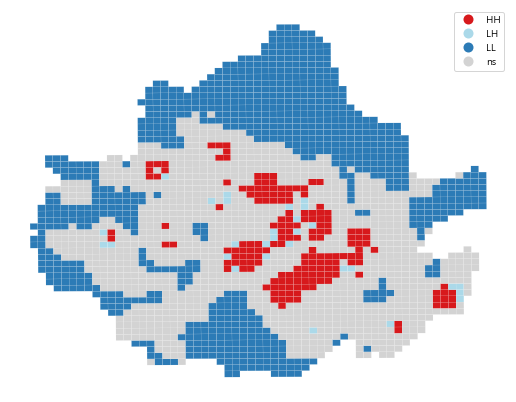

In [46]:
lisa_cluster(mil, gdf, p=0.05, figsize = (9,9))
plt.show()

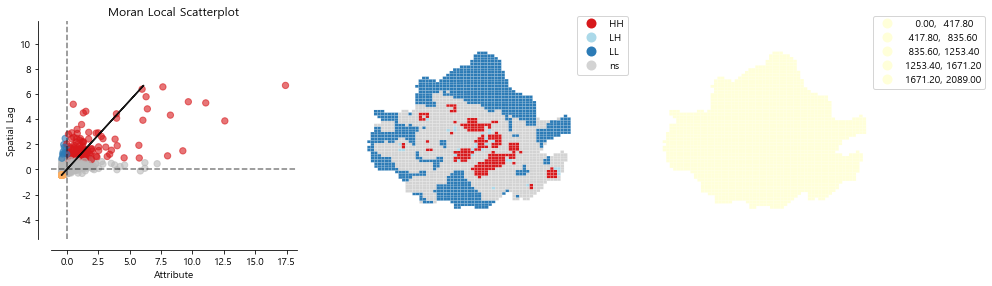

In [47]:
plot_local_autocorrelation(mil, gdf, 'gid', p=0.05)
plt.show()

In [48]:
sum(mil.q[idx] == 1), sum(mil.q[idx] == 2), sum(mil.q[idx] == 3), sum(mil.q[idx] == 4)

(178, 29, 825, 0)

In [49]:
#변수들의 데이터타입 변경

X_a = np.array(scaled_X)
y_a = np.array(y).reshape(-1,1)

In [50]:
#격자의 centroid값 저장

#gdf = gpd.GeoDataFrame(gdf, geometry=gdf.geometry)

g_coords = gdf['geometry'].centroid

x_g = g_coords.x
y_g = g_coords.y

g_coords = list(zip(x_g, y_g))

In [52]:
# GWR 분석 결과

gwr_selector_ctc = Sel_BW(g_coords, y_a, X_a, kernel='gaussian')
gwr_bw_ctc = gwr_selector_ctc.search()

In [53]:
gwr_model_ctc = GWR(g_coords, y_a, X_a, gwr_bw_ctc, fixed=False, kernel='gaussian')
gwr_result_ctc = gwr_model_ctc.fit()
gwr_result_ctc.summary()

Model type                                                         Gaussian
Number of observations:                                                2090
Number of covariates:                                                    17

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       57462393.682
Log-likelihood:                                                  -13647.281
AIC:                                                              27328.562
AICc:                                                             27330.892
BIC:                                                           57446545.765
R2:                                                                   0.610
Adj. R2:                                                              0.607

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 완전 분리를 위해.. 시간 너무 오래걸림

In [54]:
localr2_df=gwr_result_ctc.localR2
np.save("gwr_localr2.npy",localr2_df)

In [55]:
y_bar=gwr_result_ctc.y_bar
np.save("gwr_y_bar.npy",y_bar)

In [56]:
filter_tvals=gwr_result_ctc.filter_tvals()
np.save("gwr_filter_tvals.npy",filter_tvals)

In [57]:
# y fitted 값 저장
# 데이터 프레임
gwr_coef_df=pd.DataFrame(gwr_result_ctc.params, columns=scaled_X.columns)
gwr_coef_df.to_csv('gwr_coef.csv', index=False)

# np.array
gwr_coef=gwr_result_ctc.params
np.save("gwr_params.npy",gwr_coef)

gwr_coef_df

,편의점_격자별개수,경찰서_치안센터_격자별개수,상업지역면적,사고다발지역,CCTV_격자별개수,무료급식소_격자별개수,35년이상건축물수,30~34년건축물수,어린이놀이시설_격자별개수,30년이상건축물비율,단독주거건축물비율,개별주택가격,주거지역면적,경찰서_Buffer면적,공업지역면적,주거용도용적률,const
0,-0.138638,185.957170,875.830339,280.651122,1879.793029,37.987497,1526.703489,138.073922,303.733368,82.071929,-88.535411,-26.848953,-5.593408,79.097265,-39.556483,-46.214295,343.127452
1,-0.254366,187.480639,857.264368,290.848879,1758.596422,35.589548,1522.751019,144.395168,310.560672,86.111052,-89.152223,-27.528841,-4.235421,74.955591,-39.968569,-46.483110,346.851361
2,-0.386274,200.006901,820.837440,308.788145,1499.321381,31.824593,1510.379049,172.405939,318.870904,92.197553,-91.325117,-28.934070,-1.106984,68.555791,-39.918179,-46.830956,348.859244
3,0.623197,189.527991,936.714279,240.165004,2288.992441,46.289119,1537.117330,121.858857,274.725348,69.664282,-87.482482,-24.430361,-9.412869,95.894030,-37.135162,-44.942198,324.329509
4,0.322171,178.817963,940.733522,248.861757,2273.355673,45.880804,1540.118613,114.483661,283.091377,72.706340,-87.380271,-24.252962,-10.367459,92.252145,-38.119264,-44.705670,330.145214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.290813,448.184102,852.056725,309.736425,475.921221,-1.512298,1399.238476,337.617849,304.631678,222.680633,-335.602554,-70.362830,128.498267,78.367301,-19.074107,-32.175089,35.310279
2086,0.151013,448.077529,817.499134,311.149823,476.778716,-0.062239,1399.078931,345.684187,310.557913,213.474380,-335.836559,-73.090846,129.678932,78.985409,-17.071411,-31.340445,31.394986
2087,0.046247,461.426918,784.184238,320.317999,475.704222,1.084608,1387.959572,350.782756,314.061850,204.340114,-343.176917,-76.095860,131.572326,81.737633,-16.379220,-31.406684,24.940122
2088,0.012131,467.831511,759.520399,325.227777,476.391242,2.083587,1382.704761,355.224315,317.454060,196.959879,-346.762334,-77.804116,132.084372,82.404928,-15.191706,-31.098880,20.796490


In [59]:
scaled_X['geometry']=df['geometry']
scaled_X['gid']=df['gid']
scaled_X=gpd.GeoDataFrame(scaled_X,geometry='geometry')
scaled_X.to_file('scaled_X.geojson', driver='GeoJSON')

# 시각화(완전 분리)

[Text(0, 1, 'gwr_ctc')]

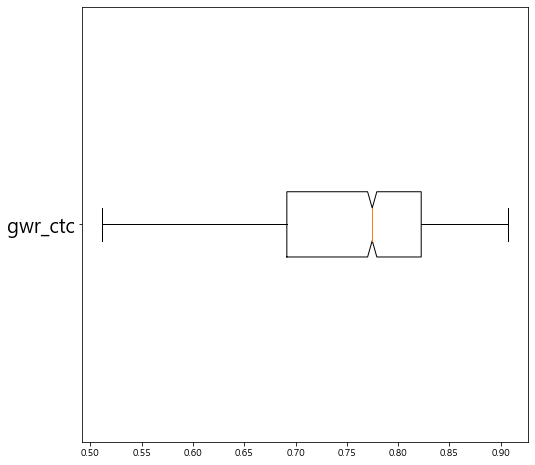

In [60]:
#모델별 R2 분포 확인
localr2=np.load("gwr_localr2.npy")

plt.figure(figsize=(8, 8))
plt.boxplot([localr2.reshape(-1,)],
            vert=False, notch=True, sym="")
plt.gca().set_yticklabels(['gwr_ctc'],
                          rotation=0, fontsize=20)

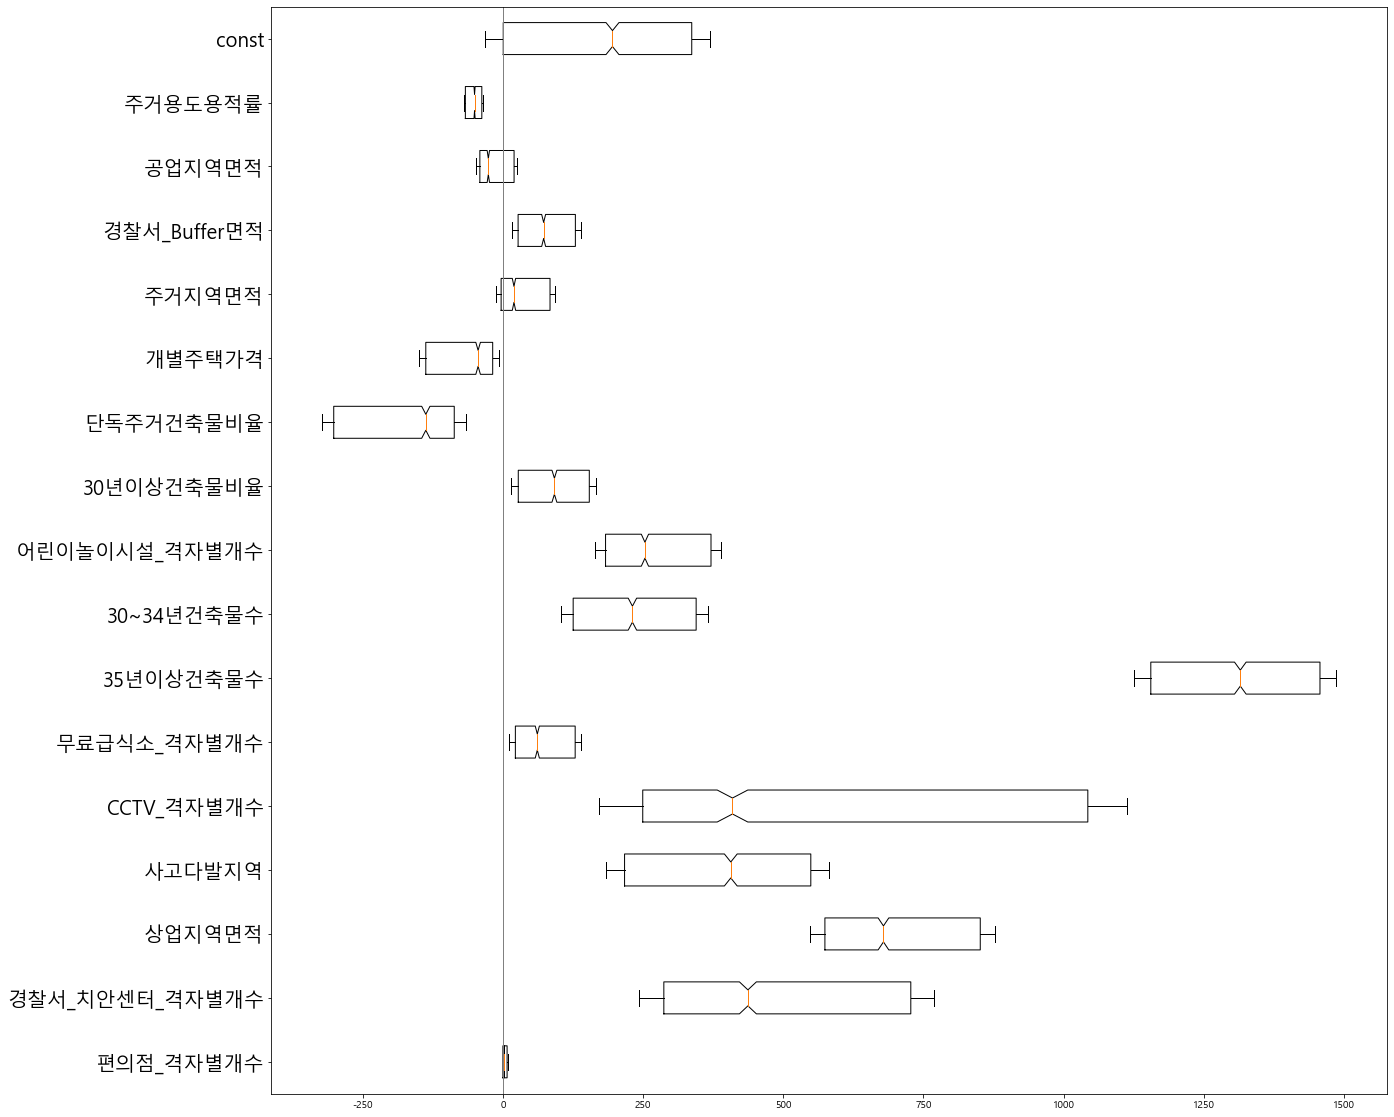

In [61]:
gwr_params=np.load("gwr_params.npy")
scaled_X=gpd.read_file('scaled_X.geojson', driver='GeoJSON')

plt.figure(figsize=(20, 20))

## 수동이긴 한데 변수가 16개라 하나씩 넣은거임.. 다시하면 수정 필요!
## 17은 gid, 18은 geometry
params=[]
for i in range(len(gwr_params[0])):
    params.append(gwr_params[:, i])

plt.boxplot(params, vert=False, notch=True, sym="", whis=0.1)

plt.gca().set_yticklabels(list(scaled_X.drop(['gid','geometry'], axis=1).columns),
                          rotation=0, fontsize=20)

plt.axvline(0, 0, 1, color='grey', linewidth='1')

### 챔고쓰
- https://deepnote.com/@siew-sook-yan/Python-Geographically-Weighted-Regression-GWR-vwNhTvvvTwe9W8iumNFSaw

In [62]:
# np array버전
gwr_params=np.load("gwr_params.npy")
filter_tvals=np.load("gwr_filter_tvals.npy")

# 분리할거면 아예 분리해야함
gwr_bw_ctc=gwr_bw_ctc

# gdf 버전(칼럼명 있음)
gwr_coef_df=pd.read_csv('gwr_coef.csv')
gwr_coef_df['geometry']=scaled_X['geometry']
gwr_coef_df['gid']=scaled_X['gid']
gwr_coef_df=gpd.GeoDataFrame(gwr_coef_df,geometry='geometry')
gwr_coef_df

78.0


,편의점_격자별개수,경찰서_치안센터_격자별개수,상업지역면적,사고다발지역,CCTV_격자별개수,무료급식소_격자별개수,35년이상건축물수,30~34년건축물수,어린이놀이시설_격자별개수,30년이상건축물비율,단독주거건축물비율,개별주택가격,주거지역면적,경찰서_Buffer면적,공업지역면적,주거용도용적률,const,geometry,gid
0,-0.138638,185.957170,875.830339,280.651122,1879.793029,37.987497,1526.703489,138.073922,303.733368,82.071929,-88.535411,-26.848953,-5.593408,79.097265,-39.556483,-46.214295,343.127452,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ...",다사49aa19ab
1,-0.254366,187.480639,857.264368,290.848879,1758.596422,35.589548,1522.751019,144.395168,310.560672,86.111052,-89.152223,-27.528841,-4.235421,74.955591,-39.968569,-46.483110,346.851361,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ...",다사49aa19ba
2,-0.386274,200.006901,820.837440,308.788145,1499.321381,31.824593,1510.379049,172.405939,318.870904,92.197553,-91.325117,-28.934070,-1.106984,68.555791,-39.918179,-46.830956,348.859244,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ...",다사49aa20aa
3,0.623197,189.527991,936.714279,240.165004,2288.992441,46.289119,1537.117330,121.858857,274.725348,69.664282,-87.482482,-24.430361,-9.412869,95.894030,-37.135162,-44.942198,324.329509,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ...",다사49ab18ab
4,0.322171,178.817963,940.733522,248.861757,2273.355673,45.880804,1540.118613,114.483661,283.091377,72.706340,-87.380271,-24.252962,-10.367459,92.252145,-38.119264,-44.705670,330.145214,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ...",다사49ab18ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.290813,448.184102,852.056725,309.736425,475.921221,-1.512298,1399.238476,337.617849,304.631678,222.680633,-335.602554,-70.362830,128.498267,78.367301,-19.074107,-32.175089,35.310279,"MULTIPOLYGON (((127.08822 37.28722, 127.08821 ...",다사63ba21aa
2086,0.151013,448.077529,817.499134,311.149823,476.778716,-0.062239,1399.078931,345.684187,310.557913,213.474380,-335.836559,-73.090846,129.678932,78.985409,-17.071411,-31.340445,31.394986,"MULTIPOLYGON (((127.08821 37.28947, 127.08820 ...",다사63ba21ab
2087,0.046247,461.426918,784.184238,320.317999,475.704222,1.084608,1387.959572,350.782756,314.061850,204.340114,-343.176917,-76.095860,131.572326,81.737633,-16.379220,-31.406684,24.940122,"MULTIPOLYGON (((127.08820 37.29173, 127.08819 ...",다사63ba21ba
2088,0.012131,467.831511,759.520399,325.227777,476.391242,2.083587,1382.704761,355.224315,317.454060,196.959879,-346.762334,-77.804116,132.084372,82.404928,-15.191706,-31.098880,20.796490,"MULTIPOLYGON (((127.08819 37.29398, 127.08818 ...",다사63ba21bb


## 지리가중회귀계수 지역별 시각화

In [63]:
# Add GWR parameters to GeoDataframe
# gdf['gwr_x0'] = gwr_params[:,0]
gdf['gwr_x1'] = gwr_params[:,1]
gdf['gwr_x2'] = gwr_params[:,2]
gdf['gwr_x3'] = gwr_params[:,3]
gdf['gwr_x4'] = gwr_params[:,4]
gdf['gwr_x5'] = gwr_params[:,5]

## cctv
gdf['gwr_x12'] = gwr_params[:,12]

# Obtain t-values filtered based on multiple testing correction
gwr_filtered_t = filter_tvals

In [64]:
def GWR_coef_plot(column):
    #Prep plot and add axis
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
    ax.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw_ctc) +')', fontsize=12)

    #Set color map
    cmap = plt.cm.seismic

    #Find min and max values of the combined dataset
    gwr_min = gdf[column].min()
    gwr_max = gdf[column].max()
    vmin = np.min([gwr_min])
    vmax = np.max([gwr_max])

    #If all values are negative use the negative half of the colormap
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    #If all values are positive use the positive half of the colormap
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    #Otherwise, there are positive and negative values so the colormap so zero is the midpoint
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    #Create scalar mappable for colorbar and stretch colormap across range of data values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    #Plot GWR parameters
    gdf.plot(column, cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})
    #If there are insignificnt parameters plot gray polygons over them
    if (gwr_filtered_t[:,1] == 0).any():
        gdf[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax, **{'edgecolor':'black'})

    #Set figure options and plot 
    fig.tight_layout()    
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=12) 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

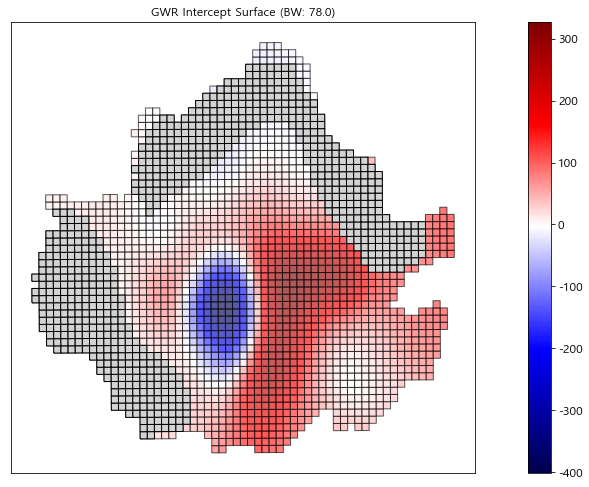

In [65]:
# cctv
GWR_coef_plot('gwr_x12')

## 회귀계수 클러스터링

In [66]:
from sklearn.cluster import KMeans 
# 스케일링 놉.
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()

df=gwr_coef_df.drop(['gid', 'geometry'], axis=1)
# df_copy_scale=scaler.fit_transform(df)
# df_copy_scale=pd.DataFrame(df_copy_scale, columns=df.columns)
# df_copy_scale

In [67]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

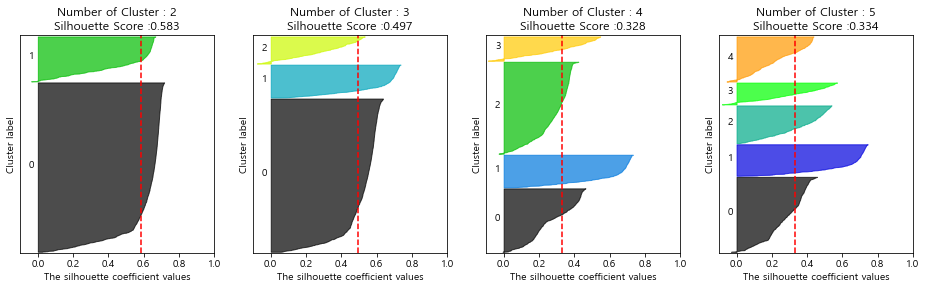

In [68]:
visualize_silhouette([ 2, 3, 4, 5], df)

In [77]:
# k-means clustering 실행(여기 숫자 바꾸면 됨)
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)  

# 결과 확인
result_by_sklearn = df.copy()
result_by_sklearn["cluster"] = kmeans.labels_
#result_by_sklearn['관할경찰서']=df['관할경찰서']
result_by_sklearn

,편의점_격자별개수,경찰서_치안센터_격자별개수,상업지역면적,사고다발지역,CCTV_격자별개수,무료급식소_격자별개수,35년이상건축물수,30~34년건축물수,어린이놀이시설_격자별개수,30년이상건축물비율,단독주거건축물비율,개별주택가격,주거지역면적,경찰서_Buffer면적,공업지역면적,주거용도용적률,const,cluster
0,-0.138638,185.957170,875.830339,280.651122,1879.793029,37.987497,1526.703489,138.073922,303.733368,82.071929,-88.535411,-26.848953,-5.593408,79.097265,-39.556483,-46.214295,343.127452,1
1,-0.254366,187.480639,857.264368,290.848879,1758.596422,35.589548,1522.751019,144.395168,310.560672,86.111052,-89.152223,-27.528841,-4.235421,74.955591,-39.968569,-46.483110,346.851361,1
2,-0.386274,200.006901,820.837440,308.788145,1499.321381,31.824593,1510.379049,172.405939,318.870904,92.197553,-91.325117,-28.934070,-1.106984,68.555791,-39.918179,-46.830956,348.859244,0
3,0.623197,189.527991,936.714279,240.165004,2288.992441,46.289119,1537.117330,121.858857,274.725348,69.664282,-87.482482,-24.430361,-9.412869,95.894030,-37.135162,-44.942198,324.329509,1
4,0.322171,178.817963,940.733522,248.861757,2273.355673,45.880804,1540.118613,114.483661,283.091377,72.706340,-87.380271,-24.252962,-10.367459,92.252145,-38.119264,-44.705670,330.145214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.290813,448.184102,852.056725,309.736425,475.921221,-1.512298,1399.238476,337.617849,304.631678,222.680633,-335.602554,-70.362830,128.498267,78.367301,-19.074107,-32.175089,35.310279,0
2086,0.151013,448.077529,817.499134,311.149823,476.778716,-0.062239,1399.078931,345.684187,310.557913,213.474380,-335.836559,-73.090846,129.678932,78.985409,-17.071411,-31.340445,31.394986,0
2087,0.046247,461.426918,784.184238,320.317999,475.704222,1.084608,1387.959572,350.782756,314.061850,204.340114,-343.176917,-76.095860,131.572326,81.737633,-16.379220,-31.406684,24.940122,0
2088,0.012131,467.831511,759.520399,325.227777,476.391242,2.083587,1382.704761,355.224315,317.454060,196.959879,-346.762334,-77.804116,132.084372,82.404928,-15.191706,-31.098880,20.796490,0


## 클러스터 시각화

In [78]:
gwr_coef_df['cluster']=result_by_sklearn['cluster']
gwr_coef_df

,편의점_격자별개수,경찰서_치안센터_격자별개수,상업지역면적,사고다발지역,CCTV_격자별개수,무료급식소_격자별개수,35년이상건축물수,30~34년건축물수,어린이놀이시설_격자별개수,30년이상건축물비율,단독주거건축물비율,개별주택가격,주거지역면적,경찰서_Buffer면적,공업지역면적,주거용도용적률,const,geometry,gid,cluster
0,-0.138638,185.957170,875.830339,280.651122,1879.793029,37.987497,1526.703489,138.073922,303.733368,82.071929,-88.535411,-26.848953,-5.593408,79.097265,-39.556483,-46.214295,343.127452,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ...",다사49aa19ab,1
1,-0.254366,187.480639,857.264368,290.848879,1758.596422,35.589548,1522.751019,144.395168,310.560672,86.111052,-89.152223,-27.528841,-4.235421,74.955591,-39.968569,-46.483110,346.851361,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ...",다사49aa19ba,1
2,-0.386274,200.006901,820.837440,308.788145,1499.321381,31.824593,1510.379049,172.405939,318.870904,92.197553,-91.325117,-28.934070,-1.106984,68.555791,-39.918179,-46.830956,348.859244,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ...",다사49aa20aa,0
3,0.623197,189.527991,936.714279,240.165004,2288.992441,46.289119,1537.117330,121.858857,274.725348,69.664282,-87.482482,-24.430361,-9.412869,95.894030,-37.135162,-44.942198,324.329509,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ...",다사49ab18ab,1
4,0.322171,178.817963,940.733522,248.861757,2273.355673,45.880804,1540.118613,114.483661,283.091377,72.706340,-87.380271,-24.252962,-10.367459,92.252145,-38.119264,-44.705670,330.145214,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ...",다사49ab18ba,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2085,0.290813,448.184102,852.056725,309.736425,475.921221,-1.512298,1399.238476,337.617849,304.631678,222.680633,-335.602554,-70.362830,128.498267,78.367301,-19.074107,-32.175089,35.310279,"MULTIPOLYGON (((127.08822 37.28722, 127.08821 ...",다사63ba21aa,0
2086,0.151013,448.077529,817.499134,311.149823,476.778716,-0.062239,1399.078931,345.684187,310.557913,213.474380,-335.836559,-73.090846,129.678932,78.985409,-17.071411,-31.340445,31.394986,"MULTIPOLYGON (((127.08821 37.28947, 127.08820 ...",다사63ba21ab,0
2087,0.046247,461.426918,784.184238,320.317999,475.704222,1.084608,1387.959572,350.782756,314.061850,204.340114,-343.176917,-76.095860,131.572326,81.737633,-16.379220,-31.406684,24.940122,"MULTIPOLYGON (((127.08820 37.29173, 127.08819 ...",다사63ba21ba,0
2088,0.012131,467.831511,759.520399,325.227777,476.391242,2.083587,1382.704761,355.224315,317.454060,196.959879,-346.762334,-77.804116,132.084372,82.404928,-15.191706,-31.098880,20.796490,"MULTIPOLYGON (((127.08819 37.29398, 127.08818 ...",다사63ba21bb,0


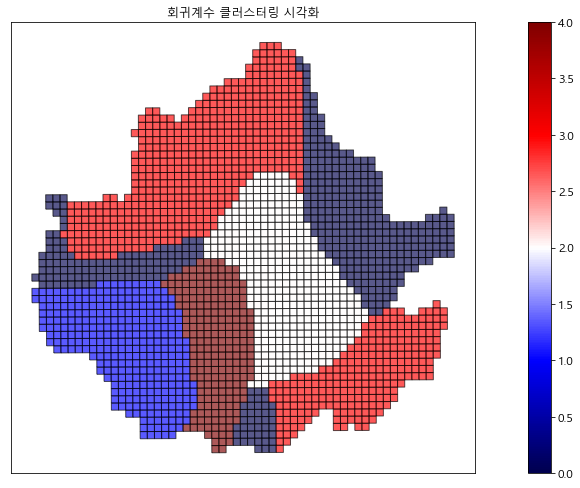

In [79]:
#Prep plot and add axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
ax.set_title('회귀계수 클러스터링 시각화', fontsize=12)

#Set color map
cmap = plt.cm.seismic

#Find min and max values of the combined dataset
gwr_min = gwr_coef_df['cluster'].min()
gwr_max = gwr_coef_df['cluster'].max()
vmin = np.min([gwr_min])
vmax = np.max([gwr_max])

#Create scalar mappable for colorbar and stretch colormap across range of data values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

#Plot GWR parameters
gwr_coef_df.plot('cluster', cmap=sm.cmap, ax=ax, vmin=vmin, vmax=vmax, **{'edgecolor':'black', 'alpha':.65})

#Set figure options and plot 
fig.tight_layout()    
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=12) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [80]:
coef_cluster_mean_df=result_by_sklearn.groupby(['cluster']).median().transpose()
coef_cluster_mean_df.to_csv('coef_cluster_mean.csv', index=False)
coef_cluster_mean_df

cluster,0,1,2,3,4
편의점_격자별개수,0.448075,4.521919,12.832148,0.417930,3.449134
경찰서_치안센터_격자별개수,285.528548,253.280100,954.015463,381.989051,1025.585263
상업지역면적,517.748731,800.597560,582.173358,740.831625,799.373210
사고다발지역,287.603365,159.145975,488.029002,564.494845,191.240062
CCTV_격자별개수,496.743365,2896.098216,326.273440,233.892421,1323.293536
무료급식소_격자별개수,32.486592,35.563247,83.472958,72.583631,291.767867
35년이상건축물수,1489.110603,1527.240401,1009.162674,1308.304374,1086.642930
30~34년건축물수,360.350328,91.320853,253.082525,183.599940,453.766526
어린이놀이시설_격자별개수,336.077922,221.892897,203.603203,366.791823,92.238570
30년이상건축물비율,88.061480,27.355187,120.431581,135.956728,-100.522759
